# Real Estate Portfolio Analysis

## Notebook Initialization and Configuration

### Add Imports

In [273]:
import pandas as pd
import alpaca_trade_api as tradeapi
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
from MCForecastTools import MCSimulation


### Add Configuration

In [127]:
NUM_TRADING_DAYS = 252
NUM_SIMULATIONS = 500
Z_SCORE_NORMAL_95 = 1.96
TICKERS = ['AMT', 'PLD', 'CCI', 'EQIX', 'PSA']
TIMEFRAME = '1D'
START_DATE_ET = '2018-11-04'
END_DATE_ET = '2021-11-04'

## Retrieve, Prepare, and Store Data

### Intialize Alpaca Trading API Client

In [249]:
# NOTE: Must have the APCA_API_KEY_ID and APCA_API_SECRET_KEY
# environment variables configured in the OS or in a .env file.
# Environment variables with this name are looked up by default
# by Alpaca.

load_dotenv()
alpaca = tradeapi.REST()

### Retrieve and Store Raw Data

In [253]:
start_date = pd.Timestamp(START_DATE_ET, tz='America/New_York').isoformat()
end_date = pd.Timestamp(END_DATE_ET, tz='America/New_York').isoformat()

prices_df = alpaca.get_barset(
                        symbols=TICKERS,
                        timeframe=TIMEFRAME,
                        limit=1000,
                        start=start_date,
                        end=end_date).df

prices_df.to_csv(Path('../data/real_estate_raw.csv'))




### Clean and Store data

In [255]:
#Check for non-float data types and missing data
display(closing_prices_df.dtypes)
display(closing_prices_df.isnull().sum())

closing_prices_df = closing_prices_df.dropna()
display(closing_prices_df.isnull().sum())

prices_df.to_csv(Path('../data/real_estate_clean.csv'))

AMT     float64
CCI     float64
EQIX    float64
PLD     float64
PSA     float64
dtype: object

AMT     0
CCI     0
EQIX    0
PLD     0
PSA     0
dtype: int64

AMT     0
CCI     0
EQIX    0
PLD     0
PSA     0
dtype: int64

## Analyze Data

### Calculate Daily Returns (aggregated)

In [261]:
closing_prices_df = prices_df.xs('close',axis='columns',level=1)

daily_returns_df = closing_prices_df.sum(axis=1).pct_change().dropna()

print('DAILY RETURNS')
print('=============')
daily_returns_df

DAILY RETURNS


time
2018-11-06 00:00:00-05:00    0.002452
2018-11-07 00:00:00-05:00    0.007596
2018-11-08 00:00:00-05:00   -0.007187
2018-11-09 00:00:00-05:00   -0.002842
2018-11-12 00:00:00-05:00    0.006539
                               ...   
2021-10-29 00:00:00-04:00   -0.008980
2021-11-01 00:00:00-04:00   -0.003872
2021-11-02 00:00:00-04:00    0.010182
2021-11-03 00:00:00-04:00   -0.003233
2021-11-04 00:00:00-04:00   -0.021217
Length: 755, dtype: float64

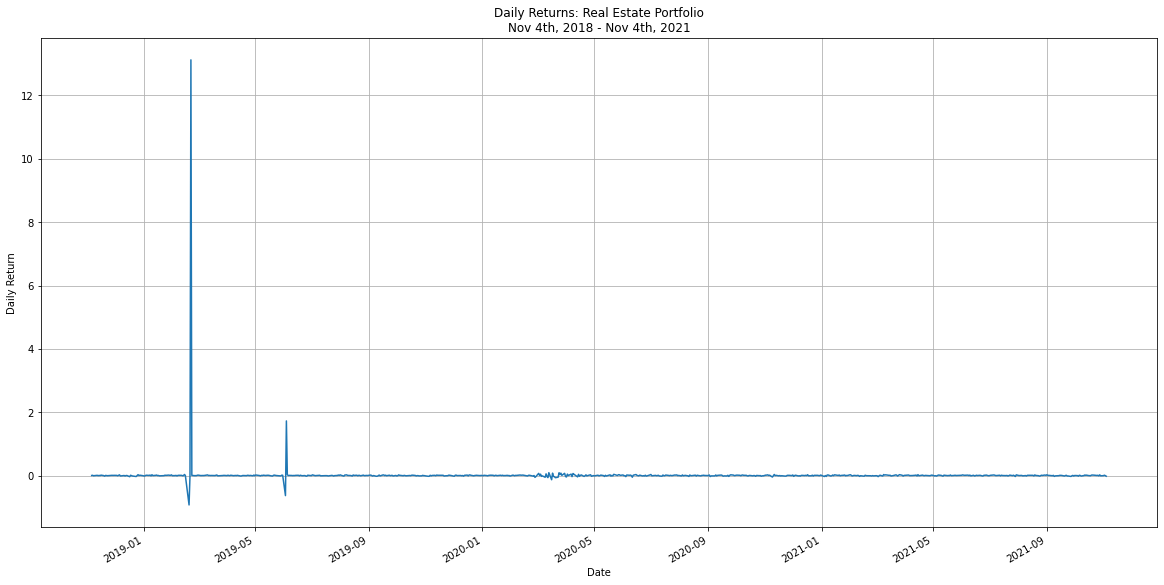

In [260]:
plot = daily_returns_df.plot(title='Daily Returns: Real Estate Portfolio\n'
                            'Nov 4th, 2018 - Nov 4th, 2021',
                            figsize=(20,10))
plot.set (xlabel='Date', ylabel='Daily Return')
plot.grid()

### Calculate Cumulative Return

In [264]:
cumulative_returns_df = (1 + daily_returns_df).cumprod()

print('CUMULATIVE RETURNS')
print('==================')
cumulative_returns_df

CUMULATIVE RETURNS


time
2018-11-06 00:00:00-05:00    1.002452
2018-11-07 00:00:00-05:00    1.010067
2018-11-08 00:00:00-05:00    1.002807
2018-11-09 00:00:00-05:00    0.999957
2018-11-12 00:00:00-05:00    1.006496
                               ...   
2021-10-29 00:00:00-04:00    1.910884
2021-11-01 00:00:00-04:00    1.903485
2021-11-02 00:00:00-04:00    1.922865
2021-11-03 00:00:00-04:00    1.916649
2021-11-04 00:00:00-04:00    1.875984
Length: 755, dtype: float64

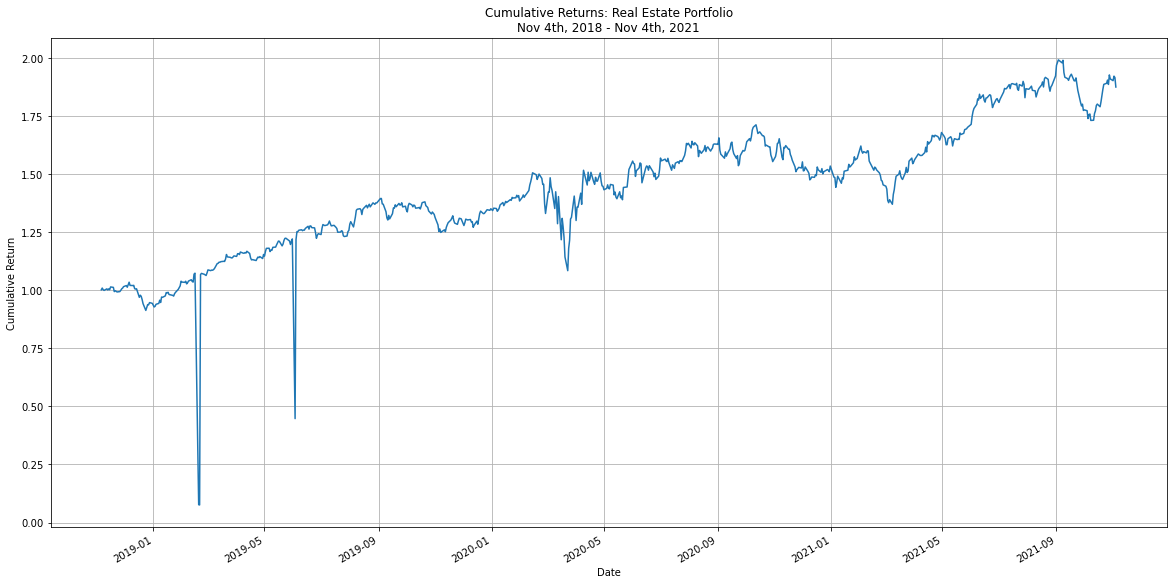

In [265]:
plot = cumulative_returns_df.plot(title='Cumulative Returns: Real Estate Portfolio\n'
                                'Nov 4th, 2018 - Nov 4th, 2021',
                                figsize=(20,10))
plot.set (xlabel='Date', ylabel='Cumulative Return')
plot.grid()

### Analyze the Volatility

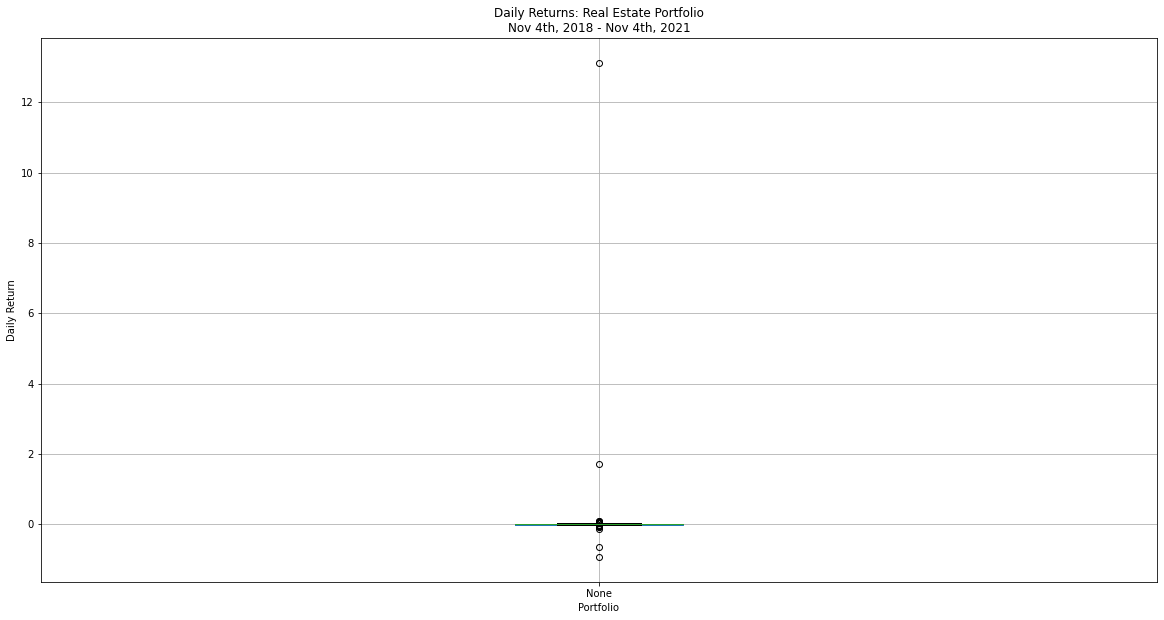

In [266]:
plot = daily_returns_df.plot(kind='box',
                        title='Daily Returns: Real Estate Portfolio\n'
                        'Nov 4th, 2018 - Nov 4th, 2021',
                        figsize=(20,10))
plot.set (xlabel='Portfolio', ylabel='Daily Return')
plot.grid()

### Analyze the Risk

In [268]:
daily_returns_std_df = daily_returns_df.std()
print('DAILY RETURNS STANDARD DEVIATION')
print('================================')
daily_returns_std_df

DAILY RETURNS STANDARD DEVIATION


0.48372651397286875

In [269]:
daily_returns_annualized_std_df = daily_returns_df.std() * np.sqrt(NUM_TRADING_DAYS)
print('ANNUALIZED STANDARD DEVIATION')
print('=============================')
daily_returns_annualized_std_df

ANNUALIZED STANDARD DEVIATION


7.678920351242529

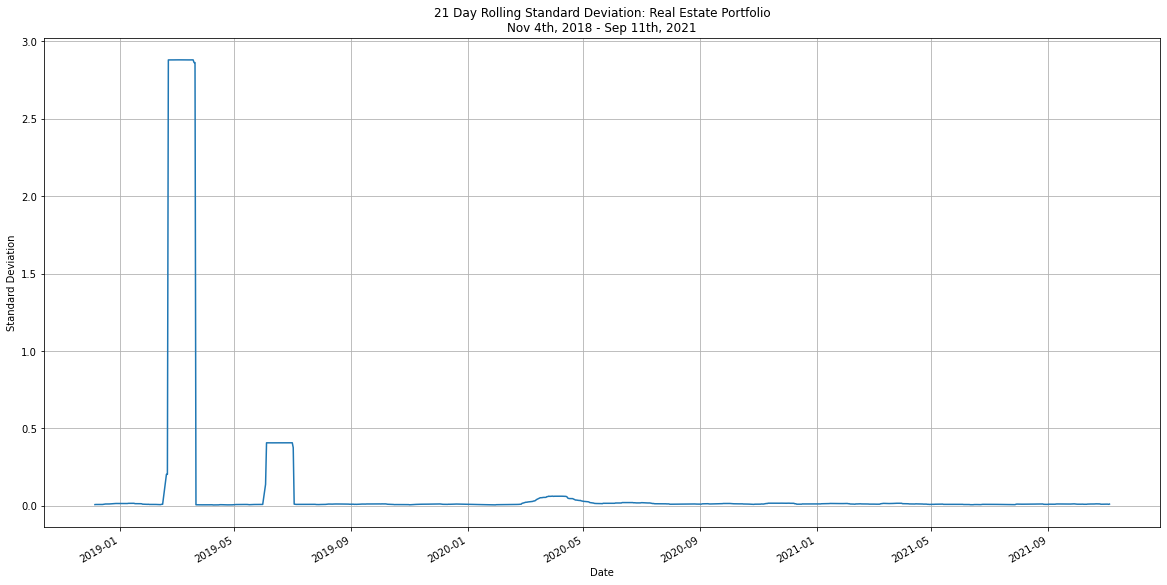

In [270]:
daily_returns_std_21_df = daily_returns_df.rolling(window=21).std()
plot = daily_returns_std_21_df.plot(title='21 Day Rolling Standard Deviation: Real Estate Portfolio\n'
                                        'Nov 4th, 2018 - Sep 11th, 2021',
                                        figsize=(20,10))
plot.set (xlabel='Date', ylabel='Standard Deviation')
plot.grid()

### Analyze the Risk-Return Profile

In [271]:
average_annual_return_df = daily_returns_df.mean() * NUM_TRADING_DAYS
print("AVERAGE ANNUAL RETURN")
print("=====================")
average_annual_return_df

AVERAGE ANNUAL RETURN


4.676073639728578

In [272]:
sharpe_ratio = average_annual_return_df / daily_returns_annualized_std_df
print("SHARPE RATIO")
print("=============")
sharpe_ratio

SHARPE RATIO


0.6089493608267392

### Run 10 Year Monte Carlo Simulation

In [229]:
years = 10
# weights default to being split evenly if not passed
mc = MCSimulation(
                portfolio_data = prices_df,
                num_simulation = NUM_SIMULATIONS,
                num_trading_days = NUM_TRADING_DAYS * years)

mc.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001403,0.999442,0.996005,1.002755,1.003165,1.022837,0.999008,1.006973,0.988462,1.002377,...,1.003470,0.999117,1.008727,0.995615,1.004726,0.996919,1.010313,1.002083,1.004670,1.003671
2,1.008146,0.999474,0.991637,1.010305,0.993209,1.024145,1.003205,1.005332,0.977944,1.007611,...,1.008735,0.994608,0.996271,0.993629,0.995739,0.996788,1.013460,0.982675,1.001857,1.018925
3,1.009346,1.003010,0.998451,1.000972,0.994247,1.041276,1.006496,1.004763,0.993802,0.994112,...,1.007806,0.992443,1.017734,0.993033,1.005009,0.991770,1.002770,0.998038,1.000219,1.017133
4,1.012231,1.001482,1.005520,1.005572,0.993481,1.037253,0.995773,0.991359,0.992273,0.986037,...,1.017749,0.993440,1.013540,0.999631,1.011066,0.991423,1.003652,1.003235,1.011083,1.024701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,10.346116,11.056198,8.229792,13.474357,22.390690,11.100818,9.147955,13.325624,11.500749,10.864628,...,9.922039,15.375002,8.994111,14.484824,14.177385,10.560711,16.145341,7.586164,18.744408,9.531047
2517,10.363617,11.011118,8.347665,13.460681,22.319262,11.150924,9.137053,13.270706,11.423818,10.706314,...,9.956573,15.343340,8.864996,14.689671,14.037169,10.651690,16.324470,7.478093,18.635080,9.658491
2518,10.306977,11.110627,8.260956,13.403175,22.455913,11.260771,9.141094,13.158171,11.502353,10.666639,...,9.947216,15.385217,8.855502,14.620031,14.077401,10.768515,16.191885,7.452067,18.587537,9.539659
2519,10.265734,11.215790,8.269763,13.481074,22.102371,11.315693,9.231063,13.272471,11.479348,10.455714,...,9.955824,15.329156,8.740841,14.562194,13.989630,10.778565,16.201805,7.321390,18.675202,9.619566


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

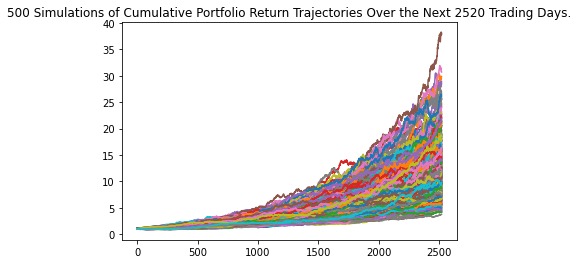

In [230]:
mc.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

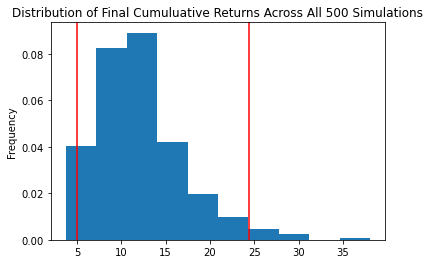

In [236]:
mc.plot_distribution()

### Calculate 10 Year Cumulative Returns

In [237]:
mc_cumulative_returns = mc.summarize_cumulative_return()
print(f'{years} year Monte Carlo summary statistics for Real Estate.')
print(mc_cumulative_returns)

10 year Monte Carlo summary statistics for Real Estate.
count           500.000000
mean             12.051706
std               4.845900
min               3.734764
25%               8.880823
50%              11.085039
75%              14.339090
max              38.073063
95% CI Lower      4.969307
95% CI Upper     24.373728
Name: 2520, dtype: float64


In [239]:
ci_lower_ten_cumulative_return = mc_cumulative_returns['mean'] - \
    mc_cumulative_returns['std'] * Z_SCORE_NORMAL_95

ci_upper_ten_cumulative_return = mc_cumulative_returns['mean'] + \
    mc_cumulative_returns['std'] * Z_SCORE_NORMAL_95

print(f"Using a 95% confidence interval, the real estate portfolio "
      f"could be down as much as {(ci_lower_ten_cumulative_return * 100): .2f}%, "
      f"and up as much as {(ci_upper_ten_cumulative_return * 100): .2f}%.")

Using a 95% confidence interval, the real estate portfolio could be down as much as  255.37%, and up as much as  2154.97%.


### Run 30 year Monte Carlo Simulation 

In [242]:
years = 30
# weights default to being split evenly if not passed
mc = MCSimulation(
                portfolio_data = prices_df,
                num_simulation = NUM_SIMULATIONS,
                num_trading_days = NUM_TRADING_DAYS * years)

mc.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006962,1.014223,1.004719,0.993146,1.002281,1.012603,0.997104,0.998025,0.994772,1.004540,...,1.003902,1.005870,1.017115,1.015530,1.004777,1.006572,1.004683,1.010672,0.993285,1.012852
2,1.018361,0.999841,1.020004,1.005887,1.004608,1.000759,0.985795,1.004293,1.005431,1.007437,...,1.013931,1.003090,1.011247,1.013656,1.010104,1.003835,1.009983,0.999203,1.000448,1.030194
3,1.027241,1.011627,1.022401,1.014563,1.017043,0.991419,0.979959,1.011509,1.005642,1.020059,...,1.014214,1.008348,1.028624,1.001729,1.010817,0.995893,1.013219,1.005200,1.012844,1.002310
4,1.020422,1.031755,1.021177,1.013193,1.015371,0.988888,0.976489,1.013550,0.994251,1.010912,...,1.007375,1.015653,1.031761,1.022780,1.011209,0.999788,1.014195,1.015795,1.017697,0.999031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,611.176367,1462.089954,353.280430,586.538120,590.461179,1317.000524,2636.729140,2121.931959,600.092258,1358.760692,...,1178.547763,583.816250,873.861180,1733.133856,4530.378951,3713.701089,849.454495,3163.406169,3021.729135,1918.922659
7557,621.006338,1453.978881,353.599978,589.201735,592.677701,1324.825881,2625.201462,2137.157399,595.050744,1372.227251,...,1199.513741,581.271468,876.865657,1723.768246,4510.680925,3700.158658,856.420248,3180.603283,2953.615259,1931.107484
7558,613.404186,1469.967269,356.904320,574.439012,586.473341,1307.499483,2637.240225,2162.609870,587.836670,1385.944087,...,1195.538922,581.720939,879.427905,1765.502566,4485.735442,3628.894031,874.494597,3214.304542,2934.137572,1915.650599
7559,619.101064,1461.558369,359.136507,576.280623,581.030269,1305.835912,2681.263359,2164.661913,605.482286,1377.930248,...,1197.539572,577.292567,883.703122,1755.999703,4456.104032,3673.434003,876.362401,3209.607321,3001.176034,1905.835873


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

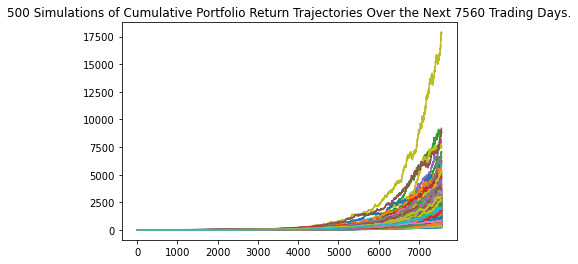

In [244]:
mc.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

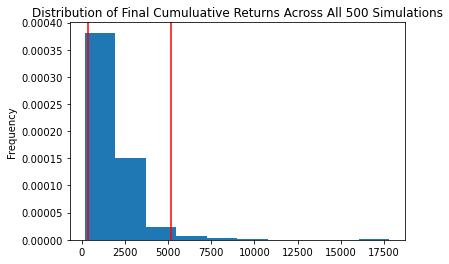

In [245]:
mc.plot_distribution()

### Calculate 30 Year Cumulative Returns

In [246]:
mc_cumulative_returns = mc.summarize_cumulative_return()
print(f'{years} year Monte Carlo summary statistics for Real Estate.')
print(mc_cumulative_returns)

30 year Monte Carlo summary statistics for Real Estate.
count             500.000000
mean             1760.855503
std              1457.944323
min               184.979493
25%               874.673063
50%              1408.448415
75%              2238.633420
max             17813.212648
95% CI Lower      368.588151
95% CI Upper     5180.285886
Name: 7560, dtype: float64


In [247]:
ci_lower_thirty_cumulative_return = mc_cumulative_returns['mean'] - \
    mc_cumulative_returns['std'] * Z_SCORE_NORMAL_95

ci_upper_thirty_cumulative_return = mc_cumulative_returns['mean'] + \
    mc_cumulative_returns['std'] * Z_SCORE_NORMAL_95

print(f"Using a 95% confidence interval, the real estate portfolio "
      f"could be down as much as {(ci_lower_thirty_cumulative_return * 100): .2f}%, "
      f"and up as much as {(ci_upper_thirty_cumulative_return * 100): .2f}%.")

Using a 95% confidence interval, the real estate portfolio could be down as much as -109671.54%, and up as much as  461842.64%.
